In [412]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [413]:
sbiStockData = pd.read_csv("./SBI-Stock-Price-Weekly.csv", index_col="Date", parse_dates=True)
sbiStockData.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis=1, inplace=True)
sbiStockData.head(-1)

,Close
Date,
2011-10-17,194.824997
2011-10-24,190.979996
2011-10-31,196.615005
2011-11-07,179.835007
2011-11-14,172.664993
...,...
2021-09-13,454.100006
2021-09-20,440.750000
2021-09-27,451.649994


<AxesSubplot:xlabel='Date'>

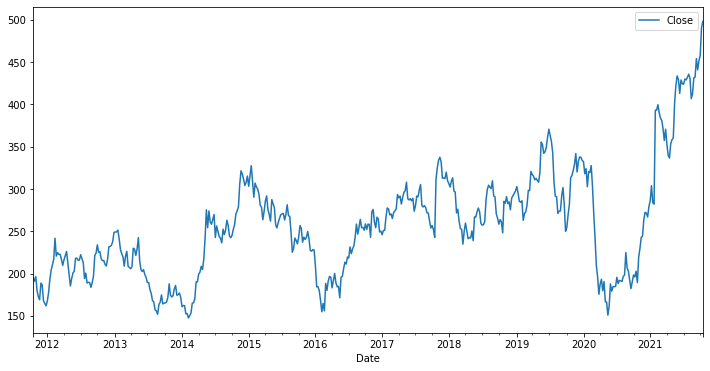

In [414]:
sbiStockData.plot(figsize=(12,6))

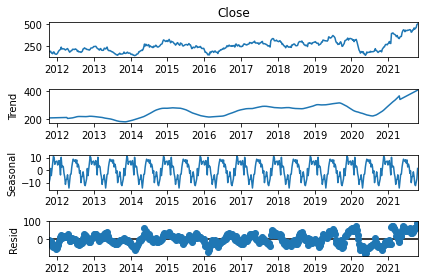

In [415]:
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(x=sbiStockData['Close'], extrapolate_trend='freq')

# results = seasonal_decompose(sbiStockData['Close'])
results.plot();

In [416]:
train_data_len = round(len(sbiStockData)*0.7)

train_data = sbiStockData[:train_data_len]
test_data = sbiStockData[train_data_len-steps:]

In [417]:
len(test_data)

207

In [418]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaled_data = scaler.fit_transform(sbiStockData)

scaled_training_data = scaler.fit_transform(train_data)
scaled_testing_data = scaler.fit_transform(test_data)

In [420]:
steps = 50

X_train = []
y_train = []
for i in range(steps, len(scaled_training_data)):
    X_train.append(scaled_training_data[i-steps:i, 0])
    y_train.append(scaled_training_data[i,0])

In [421]:
X_test = []
y_test = scaled_data[train_data_len:,:]
for i in range(steps, len(scaled_testing_data)):
    X_test.append(scaled_testing_data[i-steps:i, 0])
len(X_test)

157

In [422]:
len(y_test)

157

In [423]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_train.shape)
print(X_test.shape)

(316, 50)
(157, 50)


In [424]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(316, 50, 1)
(157, 50, 1)


In [425]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [427]:
model=Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(100))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [428]:
model.fit(X_train, y_train, batch_size=64, epochs=100)

Epoch 1/100
5/5 [==============================] - 3s 68ms/step - loss: 0.1852
Epoch 2/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0526
Epoch 3/100
5/5 [==============================] - 0s 64ms/step - loss: 0.0455
Epoch 4/100
5/5 [==============================] - 0s 63ms/step - loss: 0.0306
Epoch 5/100
5/5 [==============================] - 0s 65ms/step - loss: 0.0325
Epoch 6/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0289
Epoch 7/100
5/5 [==============================] - 0s 66ms/step - loss: 0.0265
Epoch 8/100
5/5 [==============================] - 0s 72ms/step - loss: 0.0256
Epoch 9/100
5/5 [==============================] - 0s 77ms/step - loss: 0.0236
Epoch 10/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0229
Epoch 11/100
5/5 [==============================] - 0s 78ms/step - loss: 0.0215
Epoch 12/100
5/5 [==============================] - 0s 77ms/step - loss: 0.0205
Epoch 13/100
5/5 [==============================]

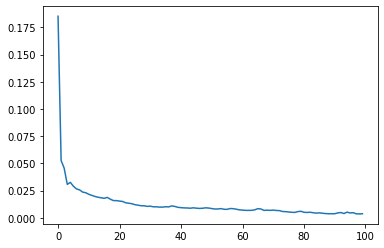

In [430]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [431]:
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)

/var/folders/83/4vs_8v5s7hz9x17bfyd6h90m0000gq/T/ipykernel_38163/3877976180.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_rep['predictions'] = test_predictions


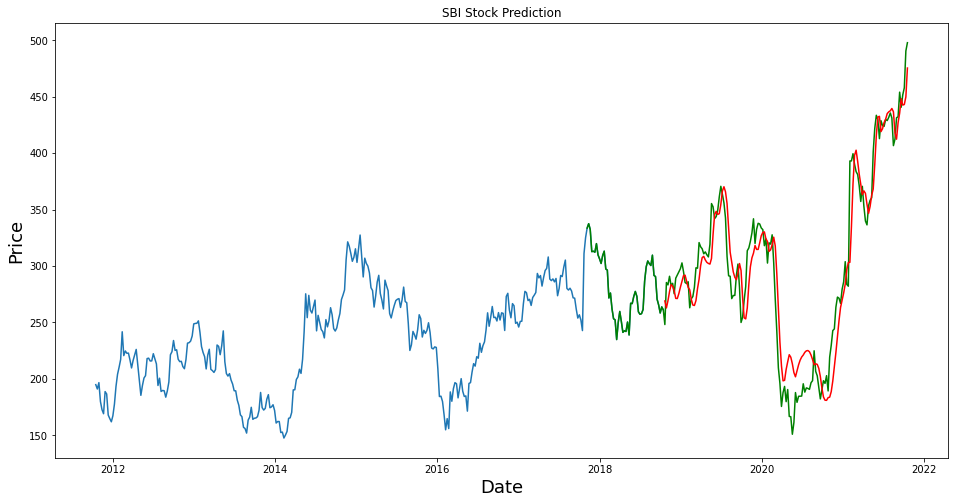

In [432]:
test_data_rep = sbiStockData[train_data_len:]
test_data_rep['predictions'] = test_predictions

plt.figure(figsize=(16,8))
plt.title("SBI Stock Prediction")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.plot(train_data['Close'])
plt.plot(test_data['Close'], "g")
plt.plot(test_data_rep['predictions'], "r")
plt.show()

In [433]:
first_eval_batch = scaled_testing_data[steps-steps:steps, 0]
current_batch = first_eval_batch.reshape((1, steps, 1))

test_predictions = []

for i in range(len(test_data_rep)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [434]:
len(test_predictions)

157

In [435]:
true_predictions = scaler.inverse_transform(test_predictions)

/var/folders/83/4vs_8v5s7hz9x17bfyd6h90m0000gq/T/ipykernel_38163/4075775447.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data_rep['true_pred'] = true_predictions


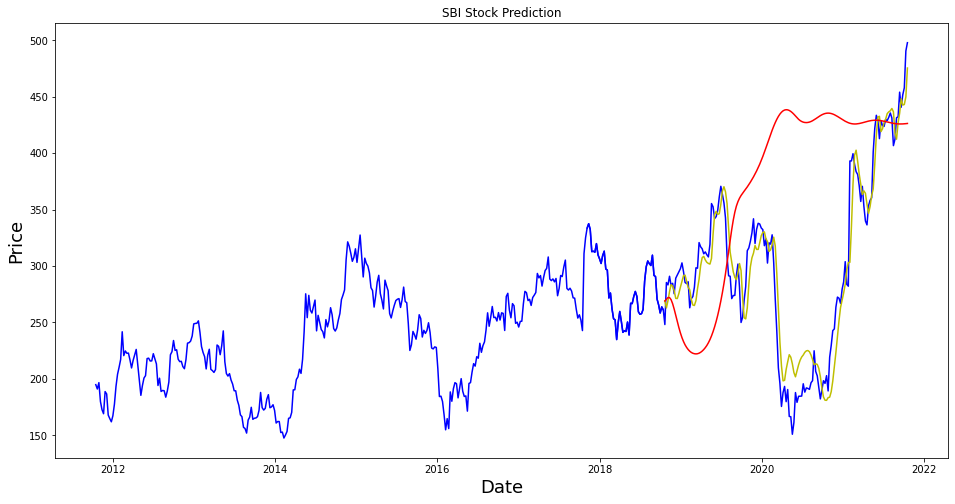

In [436]:
test_data_rep['true_pred'] = true_predictions

plt.figure(figsize=(16,8))
plt.title("SBI Stock Prediction")
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.plot(train_data['Close'], "b")
plt.plot(test_data['Close'], "b")
plt.plot(test_data_rep['predictions'], "y")
plt.plot(test_data_rep['true_pred'], "r")
plt.show()